In [1]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pearl.post_processing.bmi import calc_risk_by_group, clean_control


In [2]:
param_df = pd.read_parquet("/workspaces/pearlModel/out/S3_SA_10/combined/parameters.parquet").reset_index(drop=True)

In [3]:
param_df.columns

Index(['replication', 'group', 'new_dx', 'final_year', 'mortality_model',
       'mortality_threshold_flag', 'idu_threshold', 'seed',
       'bmi_intervention_scenario', 'bmi_intervention_start_year',
       'bmi_intervention_end_year', 'bmi_intervention_coverage',
       'bmi_intervention_effectiveness', 'sa_variables', 'prev_users_dict_hcv',
       'prev_users_dict_smoking', 'prev_users_dict_anx', 'prev_users_dict_dpr',
       'prev_users_dict_ckd', 'prev_users_dict_lipid', 'prev_users_dict_dm',
       'prev_users_dict_ht', 'prev_users_dict_malig', 'prev_users_dict_esld',
       'prev_users_dict_mi', 'prev_inits_dict_hcv', 'prev_inits_dict_smoking',
       'prev_inits_dict_anx', 'prev_inits_dict_dpr', 'prev_inits_dict_ckd',
       'prev_inits_dict_lipid', 'prev_inits_dict_dm', 'prev_inits_dict_ht',
       'prev_inits_dict_malig', 'prev_inits_dict_esld', 'prev_inits_dict_mi',
       'sa_incidence_shift_dm'],
      dtype='object')

In [4]:
bmi_int_dm_prev_variable = pd.read_parquet("/workspaces/pearlModel/out/S3_SA_10/combined/bmi_int_dm_prev.parquet")
bmi_int_dm_prev_baseline = pd.read_parquet("/workspaces/pearlModel/out/S0_SA_10/combined/bmi_int_dm_prev.parquet")

# clean to control specifications
control_bmi_int_dm_prev_variable = clean_control(bmi_int_dm_prev_variable, only_eligible=True)
control_bmi_int_dm_prev_baseline = clean_control(bmi_int_dm_prev_baseline, only_eligible=True)

# filter for only people eligible for intervention
bmi_int_eligible_risk_variable = calc_risk_by_group(control_bmi_int_dm_prev_variable, 7).compute()
bmi_int_eligible_risk_baseline = calc_risk_by_group(control_bmi_int_dm_prev_baseline, 7).compute()

In [5]:
num_samples = 10
baseline_risk = bmi_int_eligible_risk_baseline.groupby('group').sample(num_samples, replace=True)
variable_risk = bmi_int_eligible_risk_variable.groupby('group').sample(num_samples, replace=True)

In [6]:
baseline_risk_difference = (variable_risk['risk'] - baseline_risk['risk']).median()

In [7]:
baseline_risk_difference

np.float64(0.008476826918683924)

In [8]:
def calc_tornado_vals(baseline_risk_df, variable_risk_df, param_df, col_name, num_samples=10):
    
    sub_param = param_df[['replication', 'group', col_name]]
    baseline_merged = sub_param.merge(baseline_risk_df, on=['replication', 'group'], how='left').fillna(0)
    variable_merged = sub_param.merge(variable_risk_df, on=['replication', 'group'], how='left').fillna(0)
    
    quantile_val_baseline = baseline_merged.groupby('group')[col_name].quantile([0.25, 0.5, 0.75]).unstack().reset_index()
    quantile_val_variable = variable_merged.groupby('group')[col_name].quantile([0.25, 0.5, 0.75]).unstack().reset_index()
    
    tornado_df = []
    for group in quantile_val_baseline['group'].unique():
        group_df_baseline = baseline_merged[baseline_merged['group'] == group]
        group_df_variable = variable_merged[variable_merged['group'] == group]

        lesser_val_baseline = quantile_val_baseline[quantile_val_baseline['group'] == group][0.25].values[0]
        greater_val_baseline = quantile_val_baseline[quantile_val_baseline['group'] == group][0.75].values[0]
        lesser_val_variable = quantile_val_variable[quantile_val_variable['group'] == group][0.25].values[0]
        greater_val_variable = quantile_val_variable[quantile_val_variable['group'] == group][0.75].values[0]
        
        lesser_group_df_baseline = group_df_baseline[group_df_baseline[col_name] <= lesser_val_baseline].sample(num_samples, replace=True).reset_index()
        greater_group_df_baseline = group_df_baseline[group_df_baseline[col_name] >= greater_val_baseline].sample(num_samples, replace=True).reset_index()
        lesser_group_df_variable = group_df_variable[group_df_variable[col_name] <= lesser_val_variable].sample(num_samples, replace=True).reset_index()
        greater_group_df_variable = group_df_variable[group_df_variable[col_name] >= greater_val_variable].sample(num_samples, replace=True).reset_index()
        
        group_tornado_df = {
            'group': group,
            'variable': col_name,
            0.25: (lesser_group_df_variable['risk'] - lesser_group_df_baseline['risk']).median(),
            0.75: (greater_group_df_variable['risk'] - greater_group_df_baseline['risk']).median()
        }
        tornado_df.append(group_tornado_df)
        
    tornado_df = pd.DataFrame(tornado_df)
    return tornado_df

In [9]:
target_columns = ['prev_users_dict_dm', 'prev_inits_dict_dm', 'sa_incidence_shift_dm']

In [10]:
tornado_vals = []
for col in target_columns:
    tornado_vals.append(calc_tornado_vals(bmi_int_eligible_risk_baseline, bmi_int_eligible_risk_variable, param_df, col))
tornado_vals = pd.concat(tornado_vals).reset_index(drop=True)

In [11]:
tornado_vals

,group,variable,0.25,0.75
0,het_black_female,prev_users_dict_dm,-0.087018,0.041362
1,het_black_male,prev_users_dict_dm,0.272293,-0.039461
2,het_hisp_female,prev_users_dict_dm,-0.125546,0.078352
3,het_hisp_male,prev_users_dict_dm,-0.040264,0.004665
4,het_white_female,prev_users_dict_dm,0.119300,0.009941
5,het_white_male,prev_users_dict_dm,0.024756,-0.135845
6,idu_black_female,prev_users_dict_dm,-0.026753,0.329724
7,idu_black_male,prev_users_dict_dm,-0.137132,0.092094
8,idu_hisp_female,prev_users_dict_dm,-0.289322,-0.161959
9,idu_hisp_male,prev_users_dict_dm,0.014518,0.063785


In [12]:
het_black = tornado_vals[tornado_vals['group'] == 'het_black_female'].reset_index(drop=True)

In [13]:
het_black

,group,variable,0.25,0.75
0,het_black_female,prev_users_dict_dm,-0.087018,0.041362
1,het_black_female,prev_inits_dict_dm,0.087921,-0.234894
2,het_black_female,sa_incidence_shift_dm,-0.179955,-0.004806


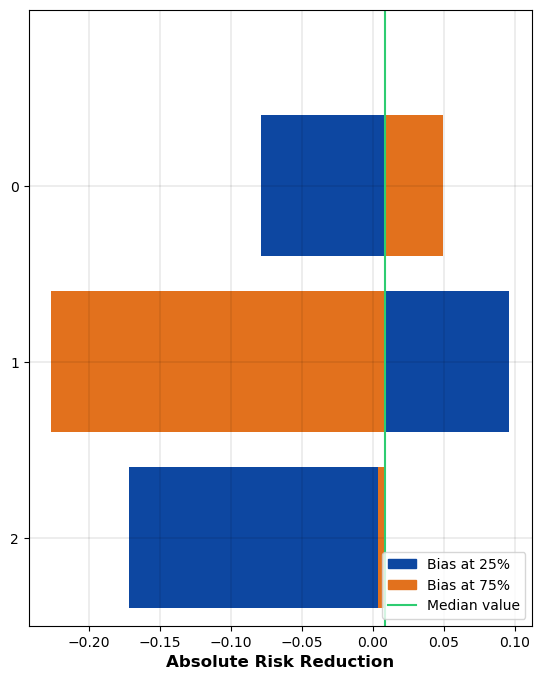

In [14]:
# Data to be visualized
value_25 = het_black.iloc[:,2].values
value_75 = het_black.iloc[:,3].values
base = baseline_risk_difference

# plot parameters
yTick_label = het_black.index
ys = range(len(yTick_label))[::-1]
height = 0.8

# Figure setup
plt.figure(figsize=(6.5,8))
color_5 = '#0d47a1'
color_95 = '#e2711d'
color_line = '#2ECC71'

# Draw bars for 25%
for y, value in zip(ys, value_25):
    plt.broken_barh([(base, value)], (y - height/2,height), facecolors=[color_5,color_5])

# Draw bars for 75%
for y, value2 in zip(ys, value_75):
    plt.broken_barh([(base, value2)], (y - height/2, height),facecolors=[color_95,color_95])

# Add vertical line for median value
plt.axvline(base, color=color_line, linewidth=1.5, label='Median value')  

# Modify the graph
plt.ylim([-0.5, 3])
plt.yticks(ys, yTick_label)
plt.grid(linewidth=0.1, color='black')
plt.xlabel('Absolute Risk Reduction', fontsize=12, fontweight='bold')

# Add legend
handles = [Patch(color=color_5, label='Bias at 25%'), Patch(color=color_95, label='Bias at 75%'),
           Line2D([0], [0], color=color_line, linewidth=1.5, label='Median value')]
plt.legend(handles=handles, loc='lower right')
